# Bible NLP

In this notebook, we will apply some natural language processing techniques to some chocen texts from the Gospels.

The goal is to verify the behavior of these techniques with these particular texts, in particular if they can capture information without changing the meaning of the text.

The verses are taken using the API from [bible-api.com](https://bible-api.com).

In [1]:
import time
import pandas as pd
import requests

# Given a reference return the text of the verse
def get_verse_text(verse: str):
    query = verse.replace(' ', '').lower()
    url = f'https://bible-api.com/{query}'
    response = requests.get(url)

    if response.status_code == 200:
        json = response.json()
        return json['reference'], json['text']
    else:
        return verse, None

def load_data(verses):
    verses_text = {}
    i = 0
    for verse in verses:
        while True:
            ref, text = get_verse_text(verse)

            if text is not None:
                i += 1
                verses_text[ref] = text
                print(f'{i}/{len(verses)}: {ref}')
                break
            time.sleep(5)

    return pd.DataFrame({'verse': verses_text.keys(), 'text': verses_text.values()})

## Classification

We will start by classifying the texts into four categories:

0. Events from the life of Jesus
1. Parables
2. Miracles
3. Teachings or discourses of Jesus

We have already classified the texts manually, the goal is to see and compare classification made by some different models (Decision Tree, Random Forest and Naive Bayes) and the real classification.

In [2]:
def classification_verses():
    # List of verses to analyze and their category:
    categories = {
        'events': 0,
        'parables': 1,
        'miracles': 2,
        'teachings': 3
    }

    verses = {
        'Matthew 2:1-12': categories['events'],         # Visit of the Magi
        'Matthew 3:13-17': categories['events'],        # Baptism of Jesus
        'Matthew 4:1-11': categories['events'],         # Temptation of Jesus
        'Matthew 5:20-48': categories['teachings'],     # Sermon on the Mount
        'Matthew 8:14-17': categories['miracles'],      # Jesus heals Peter's mother-in-law
        'Matthew 9:18-26': categories['miracles'] ,     # Jesus heals Giairus' daughter
        'Matthew 10:37-39': categories['teachings'],    # Come to me
        'Matthew 13:1-9': categories['parables'],       # Parable of the Sower
        'Matthew 13:18-23': categories['parables'],     # Parable of the Sower explained
        'Matthew 14:22-33': categories['miracles'],     # Jesus walks on water
        'Matthew 15:1-20': categories['teachings'],     # Teaching about Clean and Unclean
        'Matthew 17,1-8': categories['events'],         # Transfiguration of Jesus
        'Matthew 18:1-5': categories['teachings'],      # Who is the greatest?
        'Matthew 18:21-35': categories['parables'],     # Parable of the Unmerciful Servant
        'Matthew 26:26-29': categories['events'],       # The Last Supper
        'Matthew 27:45-54': categories['events'],       # Death of Jesus
        'Matthew 28:1-10': categories['events'],        # Resurrection of Jesus
        'Mark 1:9-11': categories['events'],            # Baptism of Jesus
        'Mark 1:21-28': categories['miracles'],         # Jesus drives out an impure spirit
        'Mark 1,29-31': categories['miracles'],         # Jesus heals Peter's mother-in-law
        'Mark 4:1-9': categories['parables'],           # Parable of the Sower
        'Mark 4:35-41': categories['miracles'],         # Jesus calms the storm
        'Mark 5:21-43': categories['miracles'],         # Jesus heals Giarius' daughter
        'Mark 6:30-44': categories['miracles'],         # Jesus feeds the five thousand
        'Mark 9:2-8': categories['events'],             # Transfiguration of Jesus
        'Mark 9:33-37': categories['teachings'],        # Who is the greatest?
        'Mark 16:1-8': categories['events'],            # Resurrection of Jesus
        'Luke 2:1-20': categories['events'],            # Birth of Jesus
        'Luke 3:21-22': categories['events'],           # Baptism of Jesus
        'Luke 4:1-13': categories['events'],            # Temptation of Jesus
        'Luke 4:38-41': categories['miracles'],         # Jesus heals Peter's mother-in-law
        'Luke 5:1-11': categories['events'],            # Jesus calls his first disciples
        'Luke 6:27-36': categories['teachings'],        # Love for enemies
        'Luke 8:4-15': categories['parables'],          # Parable of the Sower
        'Luke 8:22-25': categories['miracles'],         # Jesus calms the storm
        'Luke 8:40-56': categories['miracles'],         # Jesus heals Giarius' daughter
        'Luke 9:10-17': categories['miracles'],         # Jesus feeds the five thousand
        'Luke 9:28-36': categories['events'],           # Transfiguration of Jesus
        'Luke 9:46-48': categories['teachings'],        # Who is the greatest?
        'Luke 10:25-37': categories['parables'],        # Parable of the Good Samaritan
        'Luke 22:14-20': categories['events'],          # The Last Supper
        'Luke 23:44-49': categories['events'],          # Death of Jesus
        'Luke 24:1-12': categories['events'],           # Resurrection of Jesus
        'John 1:1-18': categories['events'],            # The Word Became Flesh
        'John 1:29-34': categories['events'],           # John Testifies About Jesus
        'John 2:1-11': categories['miracles'],          # Jesus changes water into wine
        'John 3:1-21': categories['teachings'],         # Jesus Teaches Nicodemus
        'John 19:16-30': categories['events'],          # Death of Jesus
        'John 20:1-18': categories['events'],           # Resurrection of Jesus
    }

    verses_df = load_data(verses.keys())
    verses_df['category'] = verses_df['verse'].map(verses)
    verses_df.to_csv('data/classification_verses.csv', index=False)

In [3]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import defaultdict
import numpy as np
from sklearn.model_selection import cross_val_score

def preprocess(text, n):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    ngrams_set = set()
    for i in range(1, n+1):
        processed_text = ngrams(tokens, i)
        ngrams_set.update([' '.join(gram) for gram in processed_text])
    return ngrams_set

def build_token_dictionary(tokens: pd.Series):
    tokens_dict = defaultdict(set)
    for idx, record in enumerate(tokens):
        for token in record:
            tokens_dict[token].add(idx)
    return tokens_dict
    
def entropy(df: pd.DataFrame):
    labels = set(df['category'].values)
    entropy = 0
    for label in labels:
        p = len(df[df['category'] == label]) / len(df)
        entropy -= p * np.log(p)
    return entropy
    
def information_gain(df: pd.DataFrame, H, token: str):
    token_df = df[df['tokens'].apply(lambda x: token in x)]
    token_count = len(token_df)
    token_entropy = entropy(token_df)
    return H - token_count / len(df) * token_entropy
    
def to_numeric(df: pd.DataFrame, best_features: pd.DataFrame, threshold):
    index = {}
    for idx, token in enumerate(best_features['token']):
        index[token] = idx
    data = np.zeros((len(df), threshold))
    target = np.zeros(len(df))
    
    for idx, record in df.iterrows():
        for token in record['new_text']:
            data[idx, index[token]] = 1
        target[idx] = record['category']
    return data, target

def classification(clf, df: pd.DataFrame, verses_df: pd.Series, threshold):
    df_tokens = df[:threshold]

    new_texts = []
    for tokens in verses_df['tokens']:
        intesect = set(tokens).intersection(set(df_tokens['token'].values))
        new_texts.append(intesect)
    verses_df['new_text'] = new_texts
    numeric_df, target = to_numeric(verses_df, df_tokens, threshold)
    
    # The classifier is trained with a 4-fold cross validation
    scores = cross_val_score(clf, numeric_df, target, cv=4)
    return scores.mean(), scores.std()

We will compare mean and standard deviations of the cross-validation scores of the three models varying the number of features used.

In [4]:
import os

if not os.path.exists('data/classification_verses.csv'):
    classification_verses()

verses_df = pd.read_csv('data/classification_verses.csv')
verses_df

,verse,text,category
0,Matthew 2:1-12,Now when Jesus was born in Bethlehem of Judea ...,0
1,Matthew 3:13-17,Then Jesus came from Galilee to the Jordan to ...,0
2,Matthew 4:1-11,Then Jesus was led up by the Spirit into the w...,0
3,Matthew 5:20-48,\nFor I tell you that unless your righteousnes...,3
4,Matthew 8:14-17,"When Jesus came into Peter’s house, he saw his...",2
5,Matthew 9:18-26,"While he told these things to them, behold, a ...",2
6,Matthew 10:37-39,\nHe who loves father or mother more than me i...,3
7,Matthew 13:1-9,"On that day Jesus went out of the house, and s...",1
8,Matthew 13:18-23,"\n“Hear, then, the parable of the farmer.\n\n\...",1
9,Matthew 14:22-33,Immediately Jesus made the disciples get into ...,2


In [5]:
verses_df['tokens'] = verses_df['text'].apply(preprocess, n=3)

tokens_dict = build_token_dictionary(verses_df['tokens'])
df_tokens = pd.DataFrame(zip(tokens_dict.keys(), tokens_dict.values()), columns=['token', 'verses'])

count = []
for t in df_tokens['verses']:
    count.append(len(t))
df_tokens['count'] = count
df_tokens = df_tokens[df_tokens['count'] > 1]
H = entropy(verses_df)
df_tokens['information_gain'] = df_tokens['token'].apply(lambda x: information_gain(verses_df, H, x))
df_tokens.sort_values(by='information_gain', ascending=False, inplace=True)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

mean = []
std = []
decision_tree = DecisionTreeClassifier(random_state=0)
random_forest = RandomForestClassifier(random_state=0)
naive_bayes = MultinomialNB()

x_axis = range(100, 450, 50)

for i in x_axis:
    mean_dt, std_dt = classification(decision_tree, df_tokens, verses_df, i)
    mean_rf, std_rf = classification(random_forest, df_tokens, verses_df, i)
    mean_nb, std_nb = classification(naive_bayes, df_tokens, verses_df, i)
    mean.append((mean_dt, mean_rf, mean_nb))
    std.append((std_dt, std_rf, std_nb))

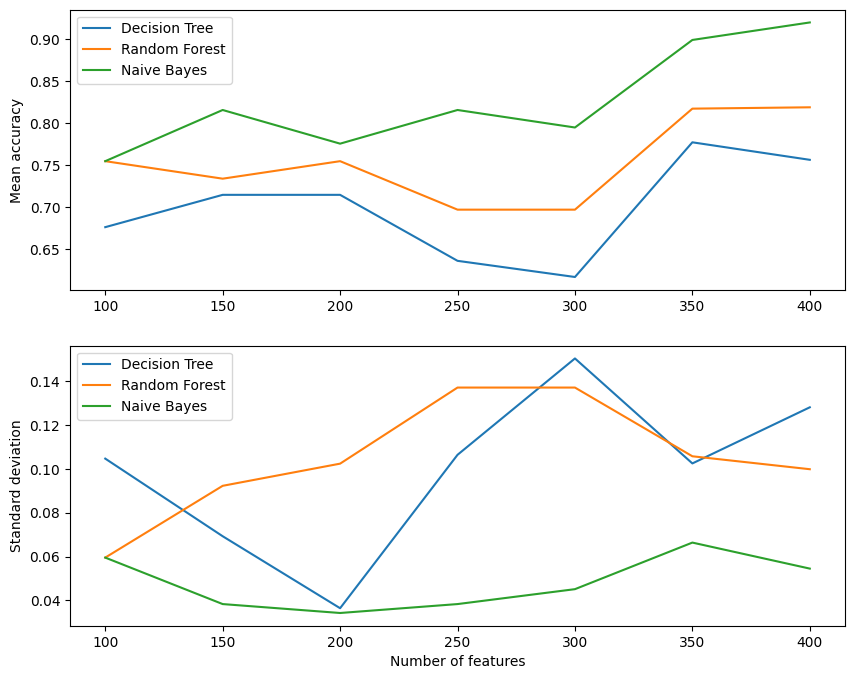

In [7]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
labels = ['Decision Tree', 'Random Forest', 'Naive Bayes']

ax1.plot(x_axis, mean, label=labels)
ax1.set(ylabel='Mean accuracy')
ax1.legend()

ax2.plot(x_axis, std, label=labels)
ax2.set(xlabel='Number of features', ylabel='Standard deviation')
ax2.legend()
plt.show()

The comparison has not indicated a clear winner, mainly because the scores change a lot during every run of the notebook. 
In general:

- the best model seems to be the Multinomial Naive Bayes, but the difference is not significant,

- the accuracy of the models is almost always upper than 70%, that is not bad, but the same consideration made before applies here too: the scores change a lot during every run of the notebook (even if the random seed is fixed).

## Clustering

In this section we will try to cluster the texts using K-Means and TD-IDF technique.

The goal is to see if parallel texts are clustered together varying the number of clusters.

In [8]:
PARALLELS = [
    {'Matthew 1:18-25', 'Luke 2:1-7'},                                      # Birth of Jesus
    {'Matthew 3:13-17', 'Mark 1:9-11', 'Luke 3:21-22', 'John 1:29-34'},     # Baptism of Jesus
    {'Matthew 4:1-11', 'Mark 1:12-13', 'Luke 4:1-13'},                      # Temptation of Jesus
    {'Matthew 21:12-13', 'Mark 11:15-18', 'Luke 19:45-46', 'John 2:14-21'}, # Cleansing of the Temple
    {'Matthew 8:14-15', 'Mark 1:29-31', 'Luke 4:38-39'},                    # The Healing of Peter's Mother-in-law
    {'Matthew 10:1-4', 'Mark 3:13-19', 'Luke 6:12-16'},                     # The Twelve Apostles
    {'Matthew 6:7-15', 'Luke 11:1-4'},                                      # The Lord's Prayer
    {'Matthew 5:43-48', 'Luke 6:27-36'},                                    # Love for Enemies
    {'Matthew 9:18-26', 'Mark 5:21-43', 'Luke 8:40-56'},                    # Jesus heals Giarius' daughter
    {'Matthew 8:28-34', 'Mark 5:1-20', 'Luke 8:26-39'},                     # Jesus heals the Gerasene demoniac
    {'Matthew 13:1-9', 'Mark 4:1-9', 'Luke 8:4-8'},                         # Parable of the Sower
    {'Matthew 13:18-23', 'Mark 4:13-20', 'Luke 8:11-15'},                   # Parable of the Sower explained
    {'Matthew 14:13-21', 'Mark 6:32-44', 'Luke 9:10-17', 'John 6:1-15'},    # Jesus feeds the five thousand
    {'Matthew 17:1-8', 'Mark 9:2-8', 'Luke 9:28-36'},                       # Transfiguration of Jesus
    {'Matthew 21:12-13', 'Mark 11:15-18', 'Luke 19:45-46', 'John 2:14-21'}, # Cleansing of the Temple
    {'Matthew 27:55-56', 'Mark 15,40-41', 'Luke 23:49', 'John 19:25-27'},   # Witnesses to the crucifixion
    {'Matthew 28:1-10', 'Mark 16:1-8', 'Luke 24:1-12', 'John 20:1-18'},     # Resurrection of Jesus
]

def clustering_verses():
    verses = set()
    for p in PARALLELS:
        verses |= p

    verses_df = load_data(verses)
    verses_df.to_csv('data/clustering_verses.csv', index=False)

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


def preprocess(text, n):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token.isalpha() and (
        token not in stopwords.words('english'))]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(
        token) for token in filtered_tokens]
    if n <= 1:
        return lemmatized_tokens
    ngram_set = []
    for i in range(1, n + 1):
        processed_text = ngrams(lemmatized_tokens, i)
        ngram_set.extend([' '.join(grams) for grams in processed_text])
    return ngram_set

In [10]:
import os
import pandas as pd

if not os.path.exists('data/clustering_verses.csv'):
    clustering_verses()

verses_df = pd.read_csv('data/clustering_verses.csv')

In [11]:
verses_df['tokens'] = verses_df['text'].apply(preprocess, n=1)
verses_df['tokens'] = verses_df['tokens'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.95)
X = vectorizer.fit_transform(verses_df['tokens'])

As metric for the accuracy of the clustering we will measure for each verses how many verses from the same set of parallel verses are in the same cluster and calculate the mean of this values.

In [12]:
def clustering(df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1234567, n_init='auto').fit(X)
    clusters = kmeans.labels_
    df['cluster'] = clusters

    guessed_parallels = []
    fractions = []
    for v in verses_df['verse']:
        v_set = None
        v_cluster = df[df['verse'] == v]['cluster'].values
        for p in PARALLELS:
            if v in p:
                v_set = p
                break
    
        i = 0
        for v_p in v_set:
            v_p_cluster = df[df['verse'] == v_p]['cluster'].values
            if v != v_p and v_cluster == v_p_cluster:
                i += 1
        guessed_parallels.append(i / (len(v_set)-1))
        fractions.append(f"{i} / {len(v_set)-1}")
    return sum(guessed_parallels) / len(guessed_parallels), fractions, clusters

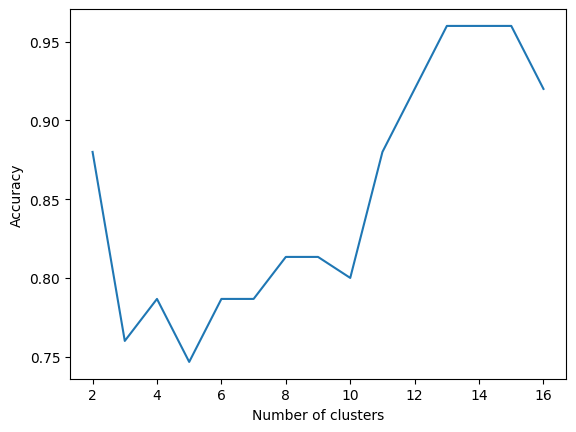

In [13]:
import matplotlib.pyplot as plt

x_axis = range(2, len(PARALLELS))
y_axis = []

best_accuracy = 0
best_clusters = None
best_n_clusters = 0
best_fractions = None
for i in x_axis:
    accuracy, fractions, clusters = clustering(verses_df, i)
    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_clusters = clusters
        best_n_clusters = i
        best_fractions = fractions
    y_axis.append(accuracy)

plt.plot(x_axis, y_axis)
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')
plt.show()

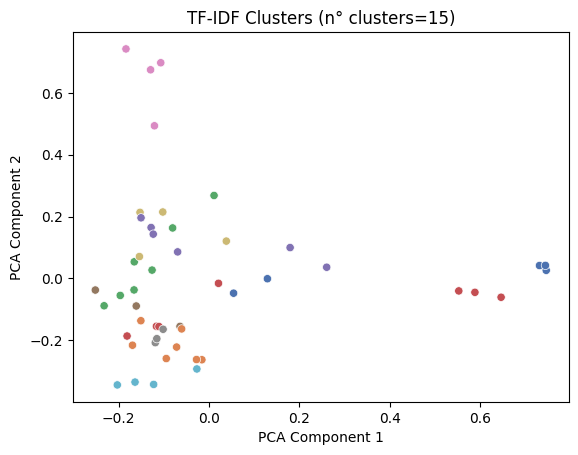

Percentage of guessed parallels: 96.00%


,verse,text,cluster,guessed parallels
14,Luke 8:11-15,\nNow the parable is this: The seed is the wor...,0,2 / 2
19,Mark 4:13-20,"He said to them,\n“Don’t you understand this p...",0,2 / 2
32,Matthew 13:18-23,"\n“Hear, then, the parable of the farmer.\n\n\...",0,2 / 2
21,John 6:1-15,"After these things, Jesus went away to the oth...",1,3 / 3
34,Luke 9:10-17,"The apostles, when they had returned, told him...",1,3 / 3
41,Mark 6:32-44,They went away in the boat to a deserted place...,1,3 / 3
23,Matthew 14:13-21,"Now when Jesus heard this, he withdrew from th...",1,3 / 3
5,John 1:29-34,"The next day, he saw Jesus coming to him, and ...",2,3 / 3
0,Luke 3:21-22,"Now when all the people were baptized, Jesus a...",2,3 / 3
11,Mark 1:9-11,"In those days, Jesus came from Nazareth of Gal...",2,3 / 3


In [14]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2, random_state=1234567)
pca_vecs = pca.fit_transform(X.toarray())
x = pca_vecs[:, 0]
y = pca_vecs[:, 1]
verses_df['cluster'] = best_clusters
verses_df['guessed parallels'] = best_fractions
verses_df['x'] = x
verses_df['y'] = y

plt.title(f"TF-IDF Clusters (n° clusters={best_n_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
sns.scatterplot(data=verses_df, x="x", y="y", hue="cluster", palette="deep", legend=False)
plt.show()

print(f"Percentage of guessed parallels: {best_accuracy*100:.2f}%")
verses_df.drop(columns=['tokens', 'x', 'y']).sort_values(by= ['cluster', 'verse'])

The results are very good: we obtained a 96% accuracy from 13 to 15 clusters, which is very similar to the real ones, but in general we observe that the accuracy is always upper than 70% for every number of clusters, which is not bad.

Badly the results are influenced by the random seed used, so for making more accurate considerations we should try different random seeds.

Another possible approach for findings parallel verses is to use a hierarchical clustering algorithm (where number of clusters are not known a priori), but we have not tried it.

## Summarization

In this section we will try to summarize some texts using Sentence Scoring and Sentence Extraction techniques.

- The Sermon on the Mount (Matthew 5-7)

- The Last Supper from the Gospel of John (John 13-17)

- The Parable of the Prodigal Son (Luke 15,11-32)

- The Passion of Jesus from the Gospel of Luke (Luke 22-23)

In [15]:
def summarizing_verses():
    verses = [
        'Matthew 5:1-7:29', # Sermon on the Mount
        'John 13:1-17:26',  # The Last Supper
        'Luke 22:1-23:56',  # The Passion
        'Luke 15:11-32',    # Parable of the Prodigal Son
    ]
    verses_df = load_data(verses)
    verses_df.to_csv('data/summarizing_verses.csv', index=False)

In [16]:
import os
import pandas as pd

if not os.path.exists('data/summarizing_verses.csv'):
    summarizing_verses()
    
verses_df = pd.read_csv('data/summarizing_verses.csv')
verses_df

,verse,text
0,Matthew 5:1-7:29,"Seeing the multitudes, he went up onto the mou..."
1,John 13:1-17:26,"Now before the feast of the Passover, Jesus, k..."
2,Luke 22:1-23:56,"Now the feast of unleavened bread, which is ca..."
3,Luke 15:11-32,"He said,\n“A certain man had two sons.\n\n\nTh..."


In [17]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
import numpy as np
import re

def preprocess(text, lemmatizer, n):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha(
    ) and token not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if n <= 1:
        return tokens

    ngrams_set = []
    for i in range(1, n+1):
        processed_text = ngrams(tokens, i)
        ngrams_set.extend([' '.join(grams) for grams in processed_text])
    return ngrams_set

def gen_summary(sentences, scores, threshold):
    summary = []
    for idx, sentence in enumerate(sentences):
        s = re.sub(r'\s+', ' ', sentence)
        if scores[idx] >= threshold:
            summary.append(s)
    return summary

def threshold(*args):
    return args[1] * np.mean(list(args[0]))

For Sentence Scoring, instead of using frequentistic methods (like TF-IDF), we will use Latent Dirichlet Allocation (LDA) to find the most important topics in the text and use the probability of the tokens in the topics as weight. If a tokens compares in more than one topic, the sum of the probabilities is used.

The score of a sentence is calculated in this way:

1. the sentence is tokenized in words and the tokens are lemmatized

2. for each token if the token is in the list of the most important tokens obtained from LDA, the score of the token is added to the score of the sentence

3. the score of the sentence is divided by the number of relevant tokens found during the previous step (in this way short sentences are not penalized)

In [18]:
from gensim import corpora, models

def text_lda(sentences):
    lemmatizer = WordNetLemmatizer()
    tokens = [preprocess(sentence, lemmatizer, 1) for sentence in sentences]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=4)

    scores = defaultdict(lambda: 0)
    for topic, _ in lda.top_topics(corpus, coherence='u_mass', topn=10):
        for score, token in topic:
            scores[token] += score

    return dict(scores)

def score_sentence_lda(sentences, lda_scores, lemmatizer):
    sentence_score = {}
    for idx, sentence in enumerate(sentences):
        score = 0
        relevant_tokens = 0
        for token in word_tokenize(sentence.lower()):
            token = lemmatizer.lemmatize(token)
            if token in lda_scores:
                score += lda_scores[token]
                relevant_tokens += 1
        sentence_score[idx] = score / relevant_tokens if relevant_tokens > 0 else 0
    return sentence_score

In [19]:
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
verses_df['sentences'] = verses_df['text'].apply(sent_tokenize)
verses_df['lda_scores'] = verses_df['sentences'].apply(text_lda)
verses_df['sentence_scores'] = verses_df.apply(lambda x: score_sentence_lda(x['sentences'], x['lda_scores'], lemmatizer), axis=1)

In [20]:
verses_df['alpha'] = [1.8, 1.5, 1.25, 1]
verses_df['summary'] = verses_df.apply(lambda x: gen_summary(x['sentences'], x['sentence_scores'], threshold(x['sentence_scores'].values(), x['alpha'])), axis=1)

for _, row in verses_df.iterrows():
    print(row['verse'])
    print('\n'.join(row['summary']))
    print(f"\nOriginal size: {len(row['sentences'])} sentences, summary size: {len(row['summary'])} sentences")
    print("\n")

Matthew 5:1-7:29
Blessed are those who mourn, for they shall be comforted.
Blessed are those who hunger and thirst after righteousness, for they shall be filled.
Blessed are the merciful, for they shall obtain mercy.
Blessed are the pure in heart, for they shall see God.
Blessed are the peacemakers, for they shall be called children of God.
Whoever, therefore, shall break one of these least commandments, and teach others to do so, shall be called least in the Kingdom of Heaven; but whoever shall do and teach them shall be called great in the Kingdom of Heaven.
Most certainly I tell you, you shall by no means get out of there, until you have paid the last penny.
For it is more profitable for you that one of your members should perish, than for your whole body to be cast into Gehenna.
For it is more profitable for you that one of your members should perish, than for your whole body to be cast into Gehenna.
Neither shall you swear by your head, for you can’t make one hair white or black.


The model used for Sentence Scoring seems to work well.

The summaries obtained are coherent with the original texts. In particular we observe a tendency to summarize the texts using long sentences, which is good for this kind of texts, but it is bad for the size of the summaries.

Very appreciated is the fact that the start of dialogs are always included in the summaries, which is very important for understanding the context (this was a problem with the summaries obtained using frequentistic methods like TF-IDF).

## Conclusions

The results obtained for the three tasks are very good, but they suffer from the non-deterministic behavior of the models used.

The classification task is the one that suffers more from this problem, but the results are still good, so we can conclude that the models used are good for this kind of texts.

Instead, the results obtained for clustering task are very good, but I think that the results are biased by the fact we know the real number of clusters, so we can't conclude that K-means is not a good algorithm for finding parallel verses, but algorithm with a non-deterministic number of clusters (like hierarchical clustering) should be tried. K-means could be used for verifying the results obtained with other algorithms.

For the summarization task, the result are promising, so I think that the model used is good for this kind of texts, but the summaries obtained quite long, so the model should be improved, for example, trying different methods for scoring the sentences and calculating the summaries.